This code should explain what resolution and pixel sigma mean in the context of DESI data, and how they are calculated. This code does not save and data, but should be able to show what is needed for calculating sigma_pixel when downloading data.

In [1]:
from desispec.io.spectra import read_spectra
from desitarget.targetmask import desi_mask
from astropy.io import fits
import numpy as np
from desispec.resolution import Resolution
from desispec.coaddition import coadd_cameras
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

Here we load in the coadd spectra file of one HEALPix tile. It can be downloaded here. https://data.desi.lbl.gov/public/dr1/spectro/redux/iron/healpix/main/dark/0/0/. Then we coadd the data from the 3 arms together to create one continuous spectra for each QSO. 

Here we sample just one QSO for the 'res' object.

In [ ]:
# Load the spectra and resolution data from the FITS file. Coadd the arms for one spectrum.
spec = read_spectra('coadd-main-dark-0.fits copy')
wave = coadd_cameras(spec).wave['brz']
#wave = spec.wave['z'] 

res = coadd_cameras(spec).resolution_data['brz'][0] 
#res = spec.resolution_data['z'][0] # dict by band, e.g., 'b', 'r', 'z'

INFO:spectra.py:451:read_spectra: iotime 0.523 sec to read spectra from:  coadd-main-dark-0.fits copy at 2025-07-09T14:11:29.293119


The 'res' object for one QSO is a 2d array. It comes from a matrix of input vs response wavelengths. Imagine light of a single wavelength, L0 being beamed into the spectrograph. Passing through the grating/prism should not split the beam, and there should be only one point of light hitting the detector at the pixel expected for L0 light. In reality, this light beam does spread by some degree, and will strike some of the pixels around the target pixel. The intensity of this light is described by the Line Spread Function (LSF) and should be a Gaussian distribution peaking at the target pixel. The image below places the target pixel for each wavelength along the center horizontal line, with pixel offsets (meaning adjacent pixels) of 
+/- 1-5 plotted above and below.

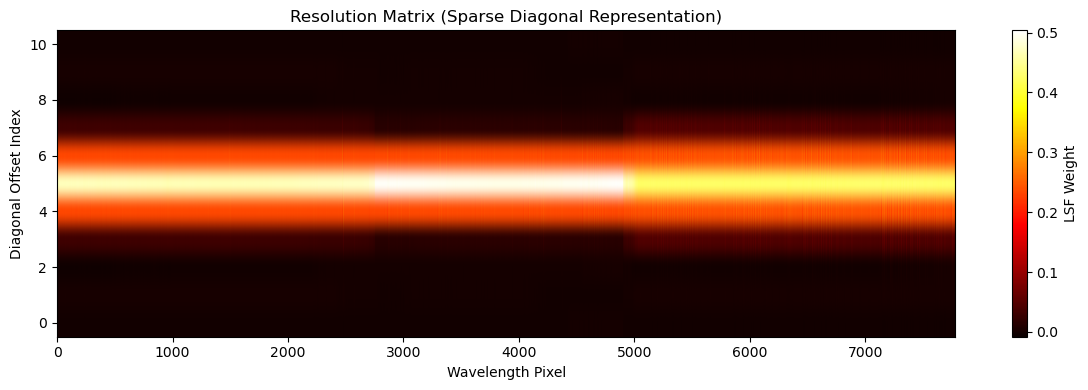

In [ ]:
# Plot the resolution offset matrix. The columns represent the Line Spread Function (LSF) for a given wavelength, 
# and the rows represent the number of pixels offset from the central pixel.

plt.figure(figsize=(12, 4))
plt.imshow(res, aspect='auto', origin='lower', cmap='hot')

# Labeling
plt.xlabel('Wavelength Pixel')
plt.ylabel('Diagonal Offset Index')
plt.title('Resolution Matrix (Sparse Diagonal Representation)')
plt.colorbar(label='LSF Weight')

plt.tight_layout()
plt.show()

Below is displayed a plot of data points and a Gaussian fit describing the LSF for a slice through the resolution matrix at a particular wavelength. Once we know the Gaussian characteristic of the LSF we know the standard deviation (sigma) for that pixel which will be used in the GP absorber detection pipeline.

Text(0, 0.5, 'Normalized LSF')

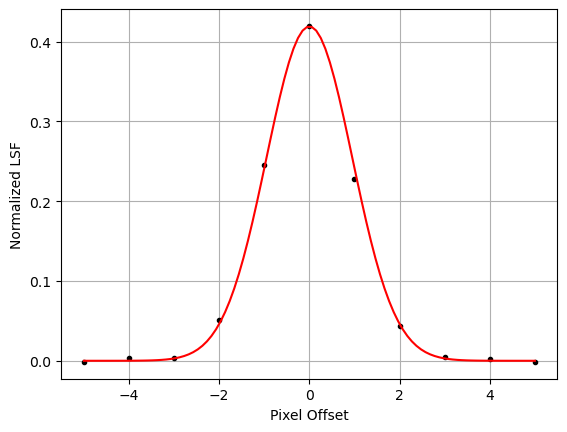

In [8]:
#Calculate sigma from Gaussian curve fit
[a,b] = res.shape
sigma_pixel = []
def fit_func(x, sig):
    return 1/sig/np.sqrt(2*np.pi) * np.exp(-x**2/(2*sig**2))

for i in range(b):
    slice = res[:, i]
    norm = sum(slice)
    slice_norm = slice / norm
    bins = np.arange(a)  # bin numbers
    center_bin = a // 2  #integer division to find the centermost bin
    bins = bins - center_bin  # shift bins to center
    
    params = curve_fit(fit_func, bins, slice_norm)  #(function, xdata, ydata)
    [sigma] = params[0]
    sigma_pixel.append(sigma) 


## Plot the LSF values for a specific wavelength. The center (pixel offset = 0) shows where the light is expected to strike the detector.
## The LSF values show the normalized strengths of light that fall on neighboring pixels.
xtest = np.linspace(-5, 5, 100)
prob_fit = fit_func(xtest, sigma)
plt.plot(bins,slice_norm,'k.')
plt.plot(xtest, prob_fit, 'r-')
plt.grid(True)
plt.xlabel('Pixel Offset')
plt.ylabel('Normalized LSF')

Below the calculated sigma_pixel array is displayed. This is the array that will go into the Matlab code pipeline. We have found sigma values of around 0.6-1.0 pixels, meaning that a single wavelength of light projected onto the detector will spead out by about 1 pixel from the target pixel.
Below this graph is a plot of resolution (R), which can be calculated from pixel_sigma. This can be compared to the DESI spectrograph documentation to check the validity of this calculation. See figure 11 on pg.13 of https://arxiv.org/pdf/2101.12181

R= [1797.14577917 1796.20681789 1801.4828203  ... 4396.00871325 4341.9958626
 4380.64829152]
[np.float64(0.8506779315491251), np.float64(0.8513117590353791), np.float64(0.8490071068726195), np.float64(0.8526051873359501), np.float64(0.8500478060333061), np.float64(0.8533450506087858), np.float64(0.8480557179588515), np.float64(0.852687657568222), np.float64(0.857645941749828), np.float64(0.8556618047523866), np.float64(0.8497616597020442), np.float64(0.8535969947866582), np.float64(0.8555115530923125), np.float64(0.853461012566482), np.float64(0.8527077440008758), np.float64(0.8547242427728996), np.float64(0.856140294101423), np.float64(0.8534670165932792), np.float64(0.8518247064521471), np.float64(0.8597758491662155), np.float64(0.8530298460854536), np.float64(0.849359907414555), np.float64(0.844444579499576), np.float64(0.85408252534917), np.float64(0.850319594668687), np.float64(0.8536915520334933), np.float64(0.8526684517270463), np.float64(0.8524404619935712), np.float64(0.852618

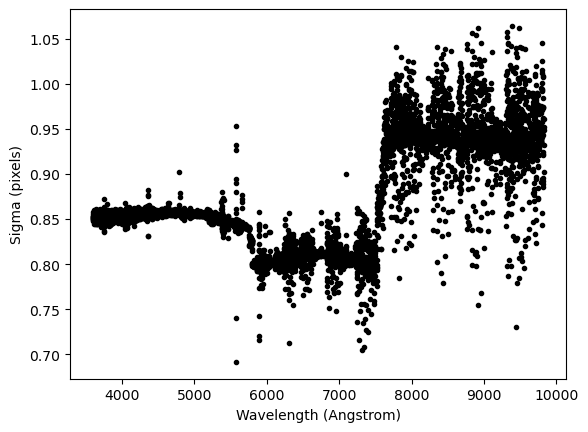

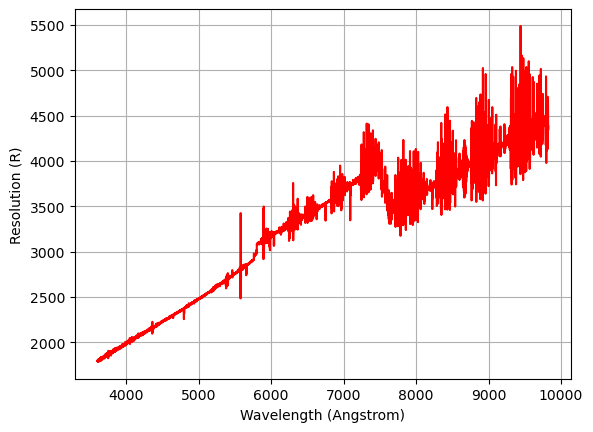

In [ ]:
# Examine the final sigma_pixel values
R = wave/(np.array(sigma_pixel)*2.3548)
print("R=",R)
## b expected: 2000-3200
## r expected: 3200-4100
## z expected: 4100-5000
print(sigma_pixel)

plt.figure()
plt.plot(wave, sigma_pixel, 'k.')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Sigma (pixels)')

plt.figure()
plt.plot(wave, R, 'r-')    
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Resolution (R)')
plt.grid(True)